In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import os
np.set_printoptions(precision=5, suppress=True)
import time
from numba import jit
from utils import * 
from inference import *
from model import * 

In [58]:
def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, sigma_p 
    '''
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    sigma_sq = gamma
    B = np.diagflat([params[5]**2, sigma_sq])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

In [39]:
class EKF_inference(inference):
    
    def __init__(self, convert_params, M):
        self.convert_params = convert_params
        self.M = M 
    
    def _minuslogP(self, params, trajs, dt):
        J, B = self.convert_params(params)
        b = params[4]
        minuslogp = _compute_minuslogP(J, B, self.M, b, trajs, dt)
        return minuslogp
    
    
@jit
def _Q(Qlin, b, p, dt):
    Q = np.copy(Qlin)
    Q[1, 1] -= 3*b*p*p*dt 
    return Q 


@jit
def _rhs(x, J, b): 
    r = J @ x
    r[1] -= b*x[1]**3
    return r 


@jit
def _RK4(x, J, b, dt):
    k1 = _rhs(x, J, b)
    
    x2 = x + k1*dt/2 
    k2 = _rhs(x2, J, b)
    
    x3 = x + k2*dt/2 
    k3 = _rhs(x3, J, b)
    
    x4 = x + dt*k3 
    k4 = _rhs(x4, J, b)
    
    return x + (k1 + 2*k2 + 2*k3 + k4)/6*dt 

@jit
def _compute_minuslogP(J, B, M, b, trajs, dt):
    '''
    traj: 2 x T 
    '''
    invM = np.linalg.inv(M)
    Qlin = J*dt + np.identity(2)
    Bdt = B*dt


    minuslogp = 0 
    for traj in trajs: 
        N = traj.shape[-1]

        V = np.zeros((2, 2))
        x = traj[:, 0]
        for n in range(1, N):
            # compute y_n | x_{n-1}
            xf = _RK4(x, J, b, dt)

            Q = _Q(Qlin, b, x[1], dt)
            Vf = Q @ V @ Q.T + Bdt 

            invCorr = np.linalg.inv(Vf + M)
            _, norm = np.linalg.slogdet(invCorr)

            y = traj[:, n]
            diff = y - xf 
            minuslogp += diff.T @ invCorr @ diff/2
            minuslogp -= norm/2

            # compute x_n | y_n 
            K = Vf @ invCorr
            V = np.linalg.inv(invM+np.linalg.inv(Vf))
            x = xf + K @ diff
    return minuslogp


### First, we make some simulations with known parameters and infer them with both inference methods

In [61]:
# simulation parameter 
dt = 3.3e-3 
n_frames = 5000
T = 0.033*n_frames
n_repeats = 2

gamma = 1
c = 15.4*gamma
mu = 0.1
epsilon = 0.256
beta = 14.65*gamma
params = [epsilon, gamma, mu, c, beta, 0.044]

J, B = convert_params(params)
print(J)
print(B)
print(np.linalg.eigvals(J))

m = FHN(params, convert_params, m_err=[0.002, 0.05])
results = m.evolve(T, dt, int(n_frames), n_repeats)

[[-0.256   0.1   ]
 [-3.9424  0.54  ]]
[[0.00194 0.02981]
 [0.02981 1.45914]]
[0.142+0.48563j 0.142-0.48563j]


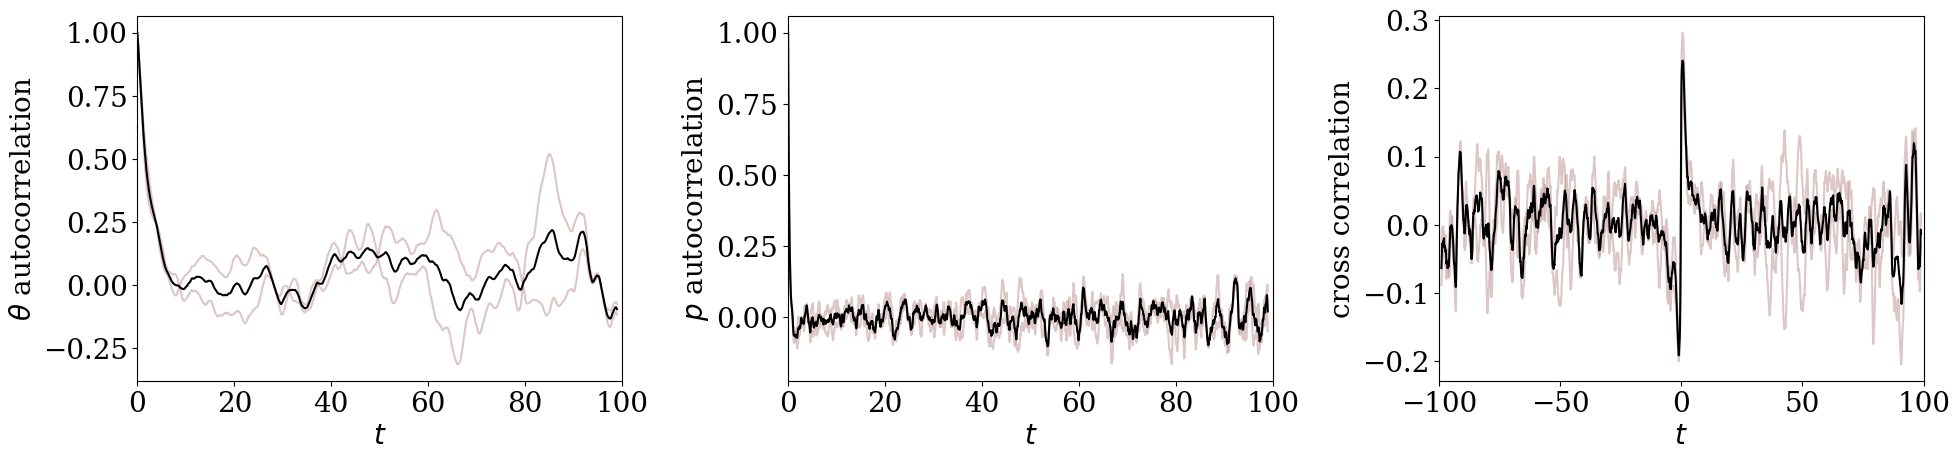

In [62]:
plot_corr(results, 3000, 0.033, colors=['rosybrown', 'black']); 

In [63]:
M = np.diagflat([1e-4, 1e-3])**2
inf = EKF_inference(convert_params, M)

guess = params

t1 = time.time() 
minuslogp = inf._minuslogP(params, results, T/n_frames)
t2 = time.time() 
print('time taken: ', t2-t1)
print(minuslogp)

time taken:  0.5624151229858398
-54595.18479645321


In [64]:
## Numerical inference
inf = EKF_inference(convert_params, M)
bounds = [[1e-6, None]]*6
t1 = time.time() 
MAP, cost = inf.inf(guess, results, (T/n_frames), bounds=bounds)
t2 = time.time() 
print('time taken: ', t2-t1)
print(MAP, cost)
print('true params:', guess, inf._minuslogP(guess, results, T/n_frames))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


time taken:  19.993638038635254
[ 0.30826  0.99169  0.09429 13.02452 18.2215   0.04697] -54724.60250184612
true params: [0.256, 1, 0.1, 15.4, 14.65, 0.044] -54595.18479645321


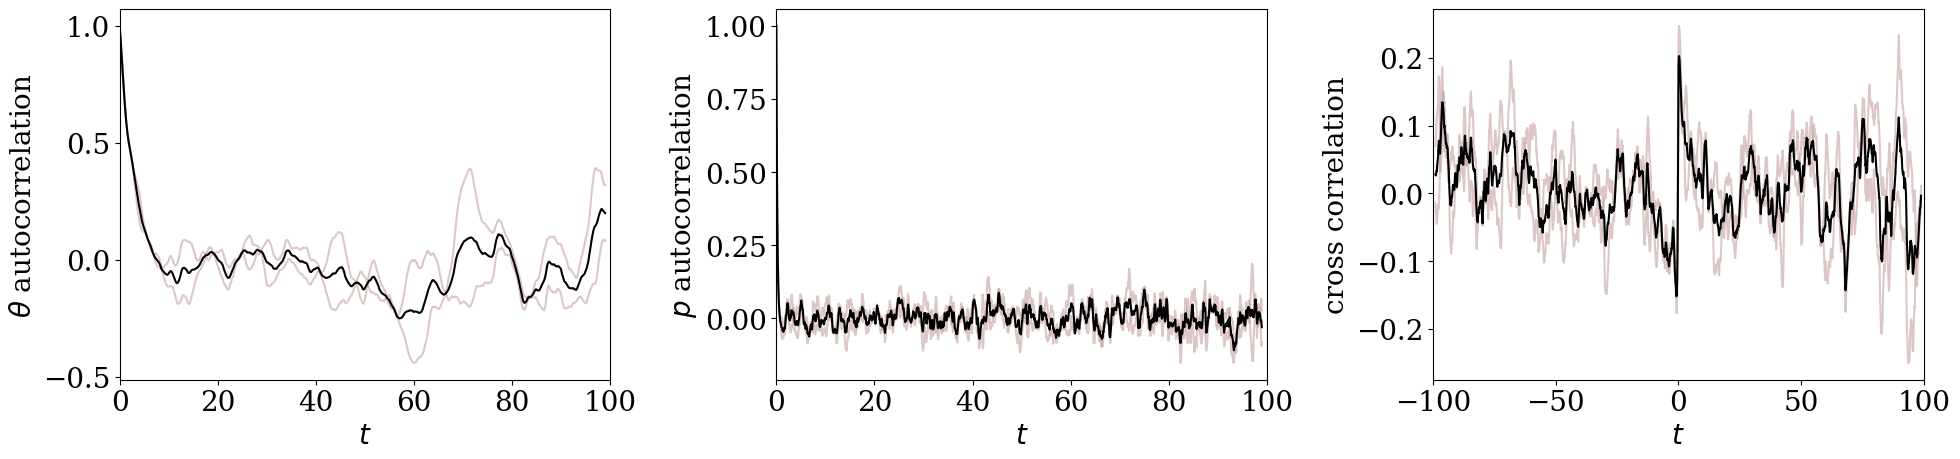

In [65]:
m = FHN(MAP, convert_params, m_err=[1e-4, 1e-3])
results = m.evolve(T, dt, int(n_frames), n_repeats)

plot_corr(results, 3000, 0.033, colors=['rosybrown', 'black']); 

## Inference with data 

In [66]:
path = 'Data/N11_ThetaPola_DATA/'
files = [f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(path+f)['POLA'])
    else: 
        theta_trajs.append(loadmat(path+f)['THETAd'])

N11_1_R200_B30_04_05_POLARIZATION.mat N11_1_R200_B30_04_05_ThetaTime.mat
N11_1_R200_B50_04_05_POLARIZATION.mat N11_1_R200_B50_04_05_ThetaTime.mat
N11_1_R200_B50_25_04_POLARIZATION.mat N11_1_R200_B50_25_04_ThetaTime.mat
N11_1_R200_B50_26_04_POLARIZATION.mat N11_1_R200_B50_26_04_ThetaTime.mat
N11_2_R200_B50_26_04_POLARIZATION.mat N11_2_R200_B50_26_04_ThetaTime.mat
N11_3_R200_B50_25_04_POLARIZATION.mat N11_3_R200_B50_25_04_ThetaTime.mat
N11_4_R200_B100_25_04_POLARIZATION.mat N11_4_R200_B100_25_04_ThetaTime.mat
N11_4_R200_B30_25_04_POLARIZATION.mat N11_4_R200_B30_25_04_ThetaTime.mat
N11_4_R200_B50_25_04_POLARIZATION.mat N11_4_R200_B50_25_04_ThetaTime.mat
N11_5_R200_B30_25_04_POLARIZATION.mat N11_5_R200_B30_25_04_ThetaTime.mat
N11_5_R200_B50_25_04_POLARIZATION.mat N11_5_R200_B50_25_04_ThetaTime.mat


In [67]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))
theta_trajs.pop(2);
pol_trajs.pop(2); 
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))

[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]


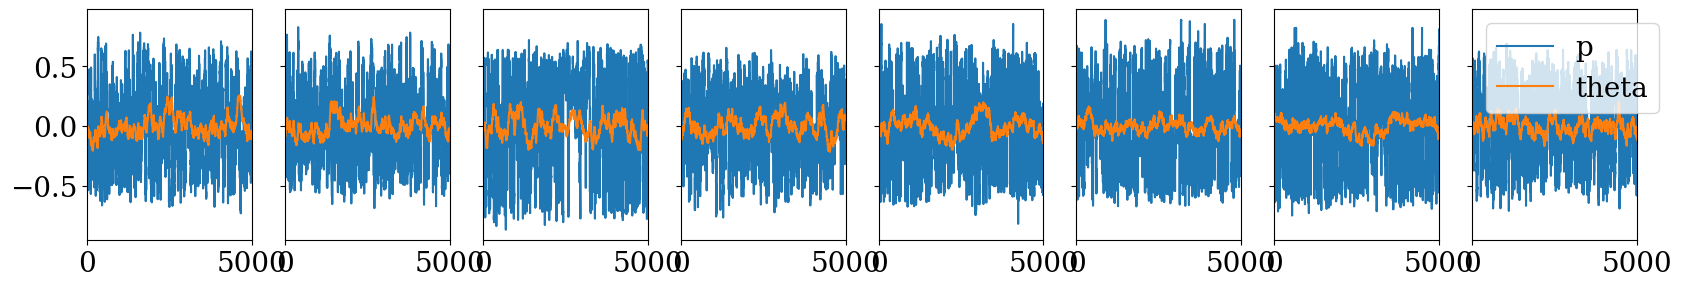

In [68]:
f1 = lambda x: (x[:, 1])/180*np.pi - np.mean(x[:, 1])/180*np.pi
f2 = lambda x: np.mean(np.sin(x[:, 1:4]), axis=1) - np.mean(np.sin(x[:, 1:4]))
f3 = lambda x: np.sin(x[:, 2]) - np.mean(np.sin(x[:, 2]))
data = [np.stack([f1(theta), f3(p)]) for (theta, p) in zip(theta_trajs, pol_trajs)]
dt = 0.03333333333333333
show([d for d in data if len(d[0]) == 5000])

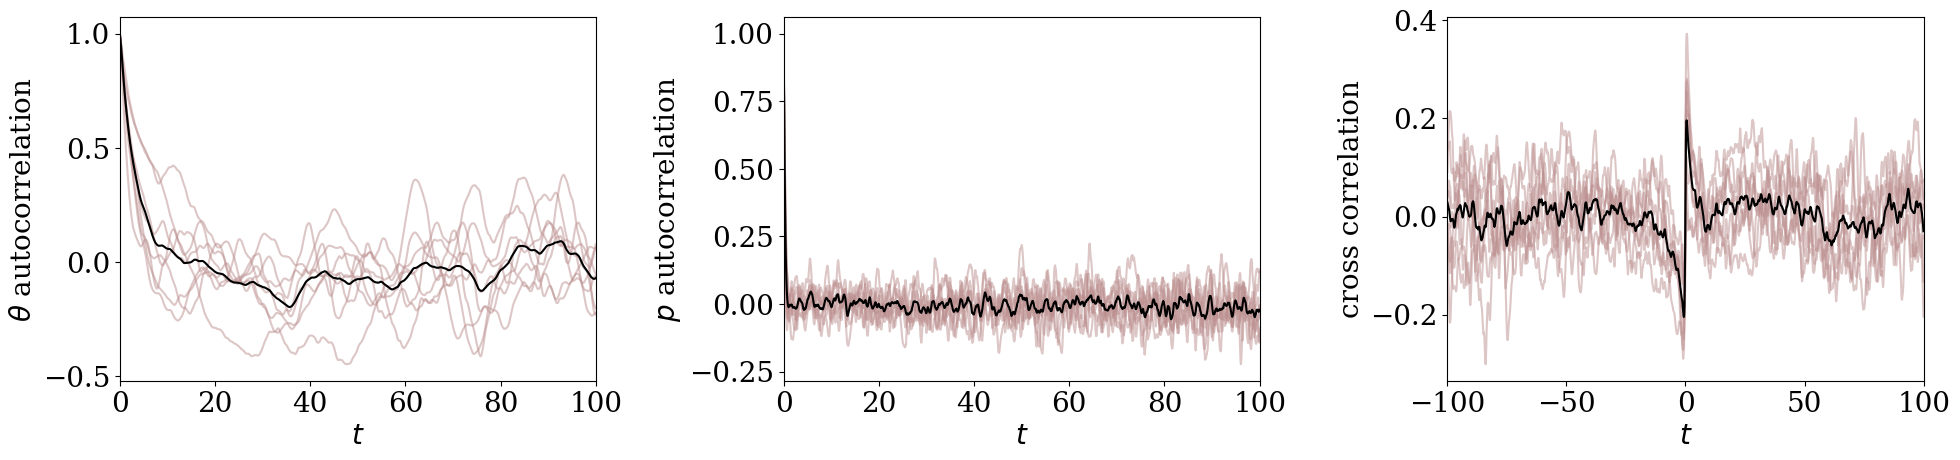

In [69]:
plot_corr([d for d in data if len(d[0]) == 5000], 3000, dt, colors=['rosybrown', 'black']); 

In [70]:
simple_data = [data[0]]

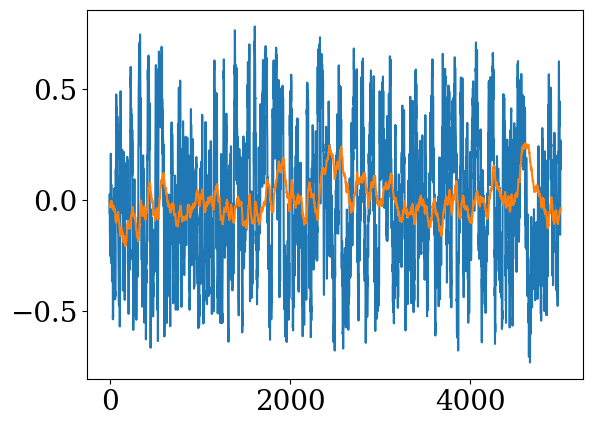

In [71]:
plt.plot(simple_data[0][1])
plt.plot(simple_data[0][0])
plt.show() 

In [75]:
guess = params
bounds = [[0, None]]*6
M = np.diagflat([0.002, 0.04])**2
dt = 0.03333333333333333

inf = EKF_inference(convert_params, M)
t1 = time.time() 
MAP, y = inf.inf(guess, simple_data, dt, bounds=bounds)
t2 = time.time() 
print('time taken: ', t2-t1)
J, B = convert_params(MAP)
print(MAP, y)
print(np.linalg.eigvals(J))
print(params, inf._minuslogP(params, simple_data, dt))

time taken:  15.536887168884277
[ 0.11156  0.29158  0.23863  5.77017 11.26202  0.02309] -32700.85359693481
[0.03463 0.93917]
[0.256, 1, 0.1, 15.4, 14.65, 0.044] -30263.321893675933


In [76]:
# MAP[2] = 0.26514

guess = np.copy(MAP)

n_frames = 5000
m = FHN(guess, convert_params, m_err=[0.002, 0.04])
print(m.J, m.b)
print(np.linalg.eigvals(J))
n_repeats = 8
sims = m.evolve(n_frames*dt, 6.6e-3, n_frames, n_repeats)

[[-0.11156  0.23863]
 [-0.64372  1.08536]] 11.262022649272932
[0.03463 0.93917]


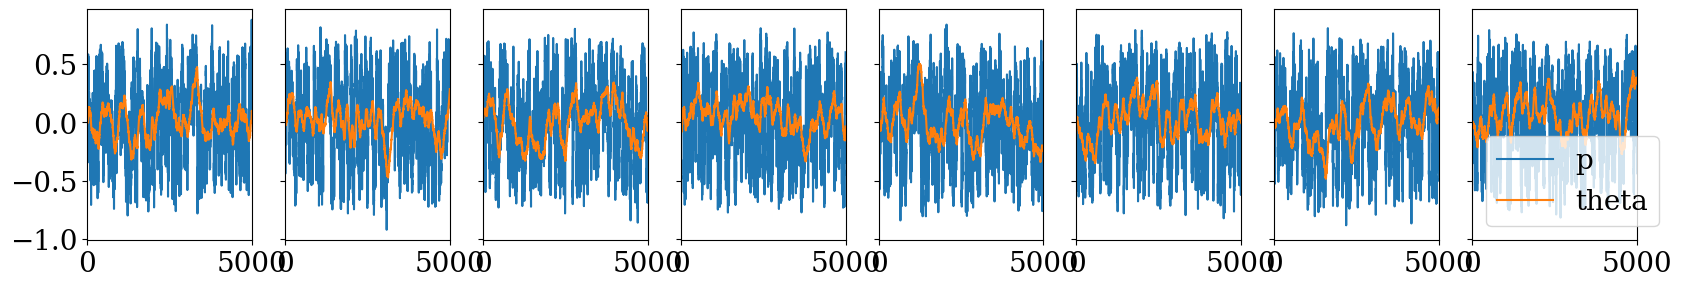

In [77]:
show(sims)

(<Figure size 2000x600 with 4 Axes>,
 array([<Axes: xlabel='$\\theta$', ylabel='$P(\\theta)$'>,
        <Axes: xlabel='$p$', ylabel='$P(p)$'>,
        <Axes: xlabel='$\\theta$', ylabel='$p$'>], dtype=object))

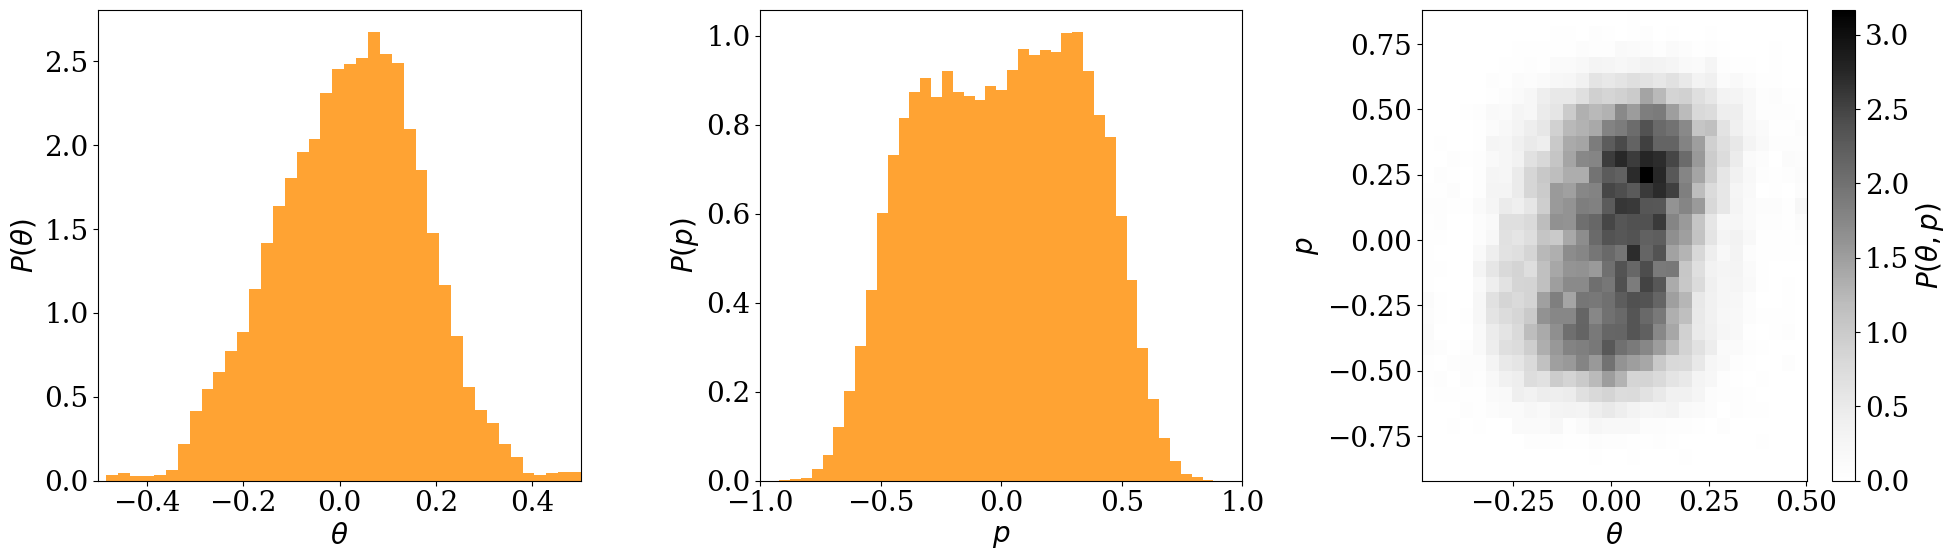

In [78]:
plot_overall_dist(sims)

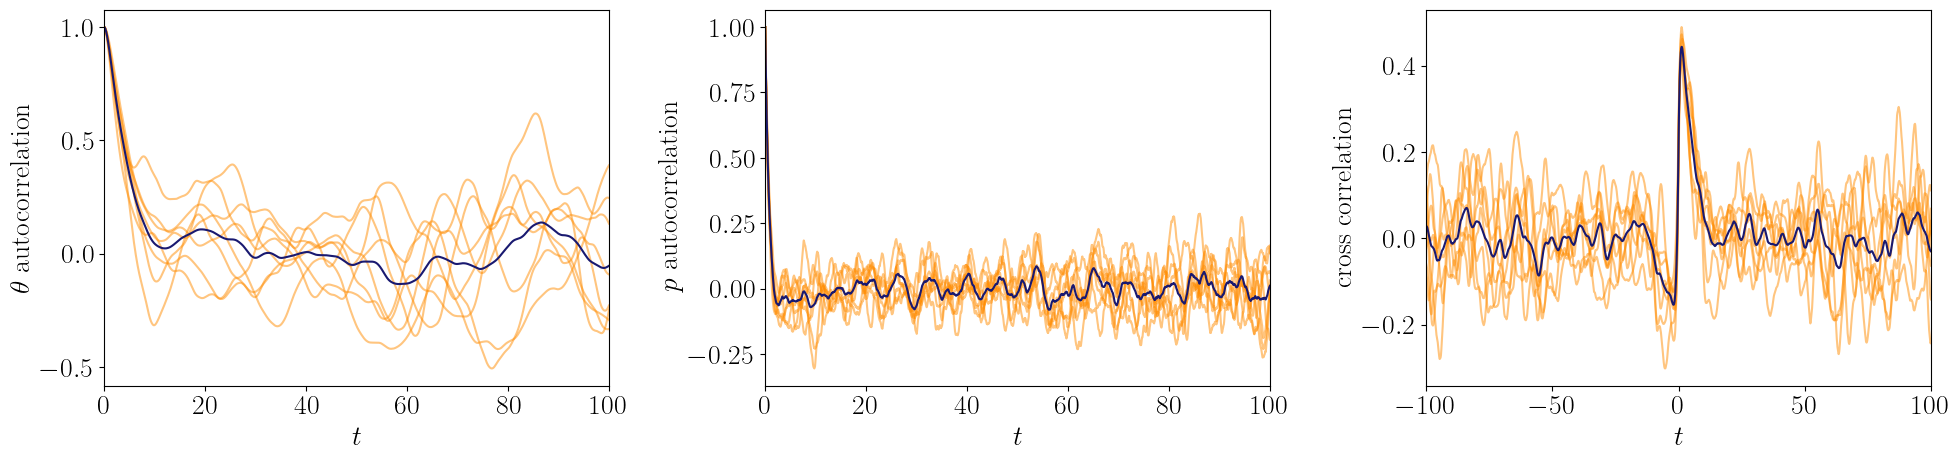

In [79]:
_, _, cc = plot_corr(sims, 3000, dt, norm=True, tex=True); 
# plt.savefig('Figures/br_corr.pdf')
plt.show() 

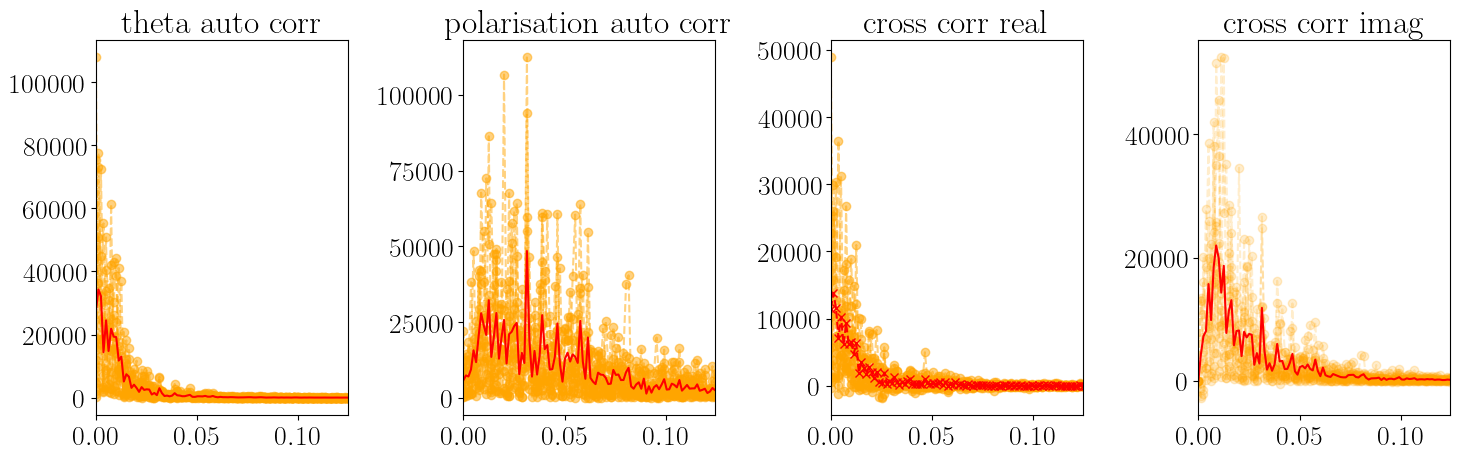

(array([27315.81238, 34303.42462, 32140.24603, ...,     0.06291,
            0.03303,     0.09892]),
 array([5726.5172 , 7335.39607, 6992.66033, ...,   31.08595,   16.81481,
          25.67273]),
 array([11492.59693   +0.j     , 13744.44922+4361.99852j,
        11627.82182+7261.99424j, ...,     0.47526   -0.81641j,
            0.11802   -0.25037j,     0.9143    +0.j     ]))

In [80]:
plot_corr_ft(np.array(sims), dt)